# Relationships between SAT scores and demographic factors


One of the most controversial issues in the U.S. educational system is the efficacy of standardized tests and whether they're unfair to certain groups. Given our prior knowledge of this topic, investigating the correlations between SAT scores and demographics might be an interesting angle to take. We could correlate SAT scores with factors like race, gender, income, and more.

Here are the links to all of the datasets we'll be using:

- [SAT scores by school](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) - SAT scores for each high school in New York City
- [School attendance](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Attendance information for each school in New York City
- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
- [AP test results](https://data.cityofnewyork.us/Education/AP-College-Board-2010-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- [Graduation outcomes](https://data.cityofnewyork.us/Education/Graduation-Outcomes-Classes-Of-2005-2010-School-Le/vh2h-md7a) - The percentage of students who graduated, and other outcome information
- [Demographics](https://data.cityofnewyork.us/Education/School-Demographics-and-Accountability-Snapshot-20/ihfw-zy9j) - Demographic information for each school
- [School survey]('https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8') - Surveys of parents, teachers, and students at each school

## Read in the data

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline


data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

## Read in the surveys


Based on the [dictionary](https://data.cityofnewyork.us/api/views/mnz3-dyi8/files/aa68d821-4dbb-4eb2-9448-3d8cbbad5044?download=true&filename=Survey%20Data%20Dictionary.xls), it looks like these are the relevant columns.

These columns give us aggregate survey data about how parents, teachers, and students feel about school safety, academic performance, and more. It also gives us the DBN, which allows us to uniquely identify the school.

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = ["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11",
                  "aca_p_11", "saf_t_11", "com_t_11", "eng_t_11", "aca_t_11", "saf_s_11", "com_s_11", 
                  "eng_s_11","aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11"]

survey = survey.loc[:,survey_fields]
data["survey"] = survey

## Add DBN columns

Each dataset appears to either have a DBN column or the information we need to create one. That means we can use a DBN column to combine the datasets. First we'll pinpoint matching rows from different datasets by looking for identical DBNs, then group all of their columns together in a single dataset.

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(
    lambda csd: str(csd) if len(str(csd)) else f'0{csd}')
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Convert columns to numeric

We'll need to convert the `SAT Math Avg. Score`, `SAT Critical Reading Avg. Score`, and `SAT Writing Avg. Score` columns in the sat_results dataset from the object (string) data type to a numeric data type. We can use the pandas.to_numeric() method for the conversion. 

If we don't convert the values, we won't be able to calculate the column `sat_score` which is the sum of shower columns.

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] =  data['sat_results'].loc[:,cols].sum(skipna=False, axis=1)

Next, we'll want to parse the latitude and longitude coordinates for each school. This enables us to map the schools and uncover any geographic patterns in the data. The coordinates are currently in the text field `Location 1` in the `hs_directory` dataset.

In [5]:
pattern = r"\((.+),.+\)"
data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].str.extract(pattern, expand=False, flags=re.I)
data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]['lat'])

pattern = r"\(.+,(.+)\)"
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].str.extract(pattern, expand=False, flags=re.I)
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]['lon'])


## Condense datasets

Since we're dealing with high schools, we're only concerned with grades 9 through 12. That means we only want to pick rows where the value in the GRADE column is `09-12` in the `class_size` dataset.

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

This column only seems to include certain subjects. We want our class size data to include every single class a school offers -- not just a subset of them. What we can do is take the average across all of the classes a school offers. This gives us unique DBN values, while also incorporating as much data as possible into the average.

In [7]:
class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

We only want to select rows where schoolyear is 20112012. This will give us the most recent year of data, and also match our SAT results data.

In [8]:
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

The Demographic and Cohort columns are what prevent DBN from being unique in the graduation data. A Cohort appears to refer to the year the data represents, and the Demographic appears to refer to a specific demographic group. In this case, we want to pick data from the most recent Cohort available, which is 2006. We also want data from the full cohort, so we'll only pick rows where Demographic is Total Cohort.

In [9]:
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP scores to numeric

AP exams have a 1 to 5 scale; 3 or higher is a passing score. Many high school students take AP exams -- particularly those who attend academically challenging institutions. AP exams are rarer in schools that lack funding or academic rigor.

It will be interesting to find out whether AP exam scores are correlated with SAT scores across high schools. To determine this, we'll need to convert the AP exam scores in the ap_2010 data set to numeric values first.

There are three columns we'll need to convert:

- AP Test Takers (note that there's a trailing space in the column name)
- Total Exams Taken
- Number of Exams with scores 3 4 or 5

In [10]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combine the datasets

Both the `ap_2010` and the `graduation` datasets have many missing DBN values, so we'll use a left join when we merge the sat_results data set with them. Since we're using a left join, our final dataframe will have all of the same DBN values as the original sat_results dataframe.

In [11]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

Now that we've performed the left joins, we still have to merge `class_size`, `demographics`, `survey`, and `hs_directory` into `combined`. Since these files contain information that's more valuable to our analysis and also have fewer missing DBN values, we'll use the inner join type.

In [12]:
to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## Add a school district column for mapping

The school district is just the first two characters of the DBN. We can apply a function over the `DBN` column of combined that pulls out the first two letters.

In [13]:
combined["school_dist"] = combined["DBN"].str[:2]

## Find correlations

Because we're interested in exploring the fairness of the SAT, a strong positive or negative correlation between a demographic factor like race or gender and SAT score would be an interesting result meriting investigation. If men tended to score higher on the SAT, for example, that would indicate that the SAT is potentially unfair to women and vice-versa.

In [14]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986212
SAT Math Avg. Score                0.971654
SAT Writing Avg. Score             0.988152
sat_score                          1.000000
AP Test Takers                     0.537677
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.086350
lon                               -0.055850
Name: sat_score, Length: 68, dtype: float64


## Plotting survey correlations

In [15]:
survey_fields.remove("DBN")

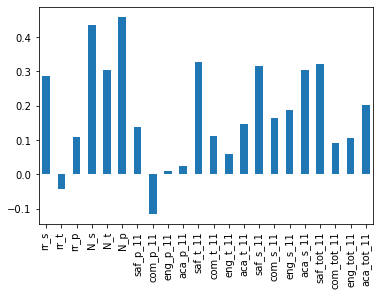

In [16]:
correlations[survey_fields].plot.bar()
plt.show()

There is a correlation between the number of answered (`N_s`, `N_t`, `N_p`)  surveys and the result of `sat_score`.


The safety perceived by students and teachers ((`saf_s_10`, `saf_t_10`, `saf_tot_10`) has a positive correlation related to sat_score. It can be said that being in an environment that is persuaded as safe the results of sat_score are higher.


There is a correlation between the perception of student perceived academic standards, but not like the perceived academic standards of parents and teachers.

## Exploring Safety and SAT Scores

We noticed that `saf_t_11` and `saf_s_11`, which measure how teachers and students perceive safety at school, correlated highly with `sat_score`.

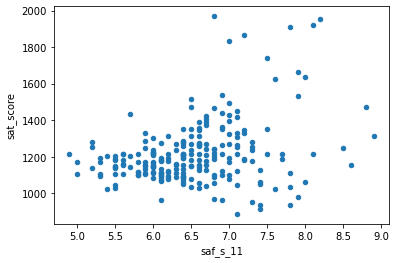

In [17]:
combined.plot(kind='scatter', y='sat_score', x='saf_s_11')
plt.show()

We can see that there is no clear relationship between the data, but an analysis of can be done with a subset of data around the values 5 and 7 of `saf_s_11`.

In [18]:
combined.groupby(by='boro').agg(np.mean)['saf_s_11']

boro
Bronx            6.589796
Brooklyn         6.370755
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64

We can observe that the average security of the different municipalities is around 6.5.

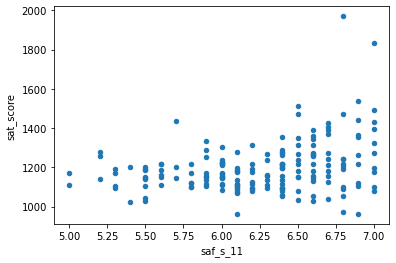

In [19]:
safety = combined[combined['saf_s_11'].between(5, 7.0)]
safety.plot(kind='scatter', y='sat_score', x='saf_s_11')
plt.show()

In the subgroup of the values around the safety average in each municipality, we can see a slightly positive correlation.

##  Exploring Race and SAT Scores

There are a few columns that indicate the percentage of each race at a given school:

- white_per
- asian_per
- black_per
- hispanic_per

By plotting out the correlations between these columns and sat_score, we can determine whether there are any racial differences in SAT performance.

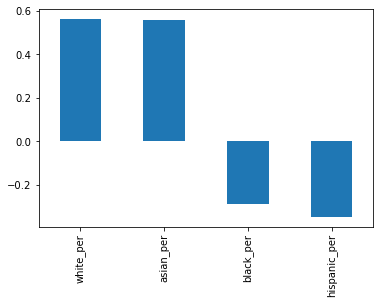

In [20]:
race_columns = ["white_per", "asian_per", "black_per", "hispanic_per"]
combined.corr()["sat_score"][race_columns].plot.bar()
plt.show()

We can observe that the racial groups `black` and `hispanic` have a negative correlation.

<AxesSubplot:xlabel='hispanic_per', ylabel='sat_score'>

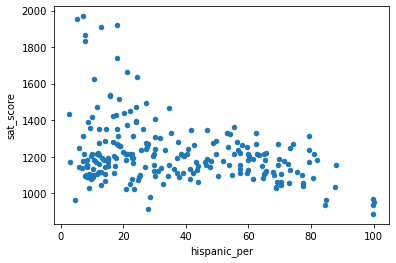

In [21]:
combined.plot(kind='scatter', x='hispanic_per', y='sat_score')

In [22]:
print(combined[combined["hispanic_per"] > 95]["SCHOOL NAME"])

7                 INTERNATIONAL SCHOOL FOR LIBERAL ARTS
42     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
119                           MULTICULTURAL HIGH SCHOOL
152              PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


They appear to be schools for recently migrant students who are learning English, this can explain the low SAT scores.

In [23]:
print(combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"])


17                          BRONX HIGH SCHOOL OF SCIENCE
53                        BROOKLYN TECHNICAL HIGH SCHOOL
193    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
222                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


They seem to be specialized schools in science or technical schools this cannot be taken as a coincidence of the low SAT scores.

## Exploring Gender and SAT Scores

There are two columns that indicate the percentage of each gender at a school:

- male_per
- female_per

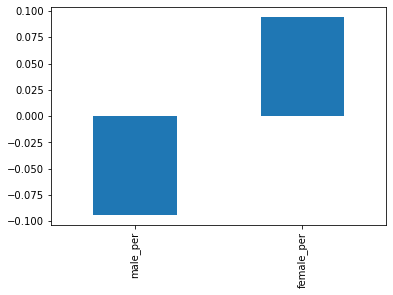

In [29]:
combined.corr()["sat_score"][['male_per', 'female_per']].plot.bar()
plt.show()

We can see that the two genders have a strong correlation with `sat_score`, but the `female` gender has a positive correlation.

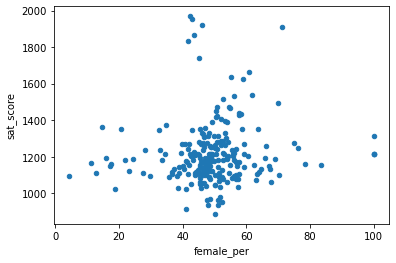

In [44]:
combined.plot(kind='scatter', y='sat_score', x='female_per')
plt.show()

Schools with a percentage between 40 and 60 of female students are present a positive correlation with a score of 1100 to 1600.

In [57]:
female = combined[(combined['female_per'] > 60.0) & (combined['sat_score'] > 1700)]
female['SCHOOL NAME']

168    TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The schools are specialized science schools and they have an admissions process, this may be a reason why students have high SAT scores, but it does not seem to be related to the fact that they have a high percentage of female students.

## Exploring AP Scores vs. SAT Scores

In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because total_enrollment is highly correlated with sat_score, we don't want to lead to bias results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

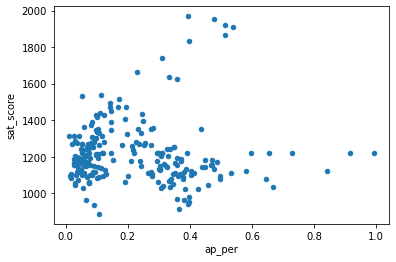

In [51]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']
combined.plot(kind='scatter', y='sat_score', x='ap_per')
plt.show()

There is a slight positive correlation between the 10 and 20 percent of students that took an AP exam but it seems that after this it begins to decrease or there is no correlation.